# Convolutional Networks

In this tutorial we will present implementation of Convolutional Networks in PyTorch. The scope of this tutorial will be:

* To introduce you to some basic network architectures and datasets that are widely used in practice.
* To realize how much better can convolutional networks perform comparing to standard fully connected networks.
* To familiarize ourselves with some famous state-of-the-art architectures for image recognition.

In [2]:
# Initialization: importing the packages that we will use
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Google colab offers time limited use of GPU for free

################# Configuration  ######################
IMAGE_SIZE = 32 # bigger image size improves performance but makes training slower.

# Training parameters 
BATCH_SIZE = 32
PATH = './cifar_net.pth'

In [3]:
# Dataset and Trasformations
import torchvision
import torchvision.transforms as transforms

############# Datasets and Dataloaders ################
transform_train = transforms.Compose([
    transforms.ToTensor(), # The output of torchvision datasets are PILImage images of range [0, 1].
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(), # we want our network to be robust over geometrical transformations that leave the image semantically invariant
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #  We transform them to Tensors of normalized range [-1, 1].
    # (mean, mean, mean) , (std, std, std): output[channel] = (input[channel] - mean[channel]) / std[channel]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
output_size = 10
     

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
from torch.utils.data import DataLoader

# Defining DataLoaders
train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
            test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

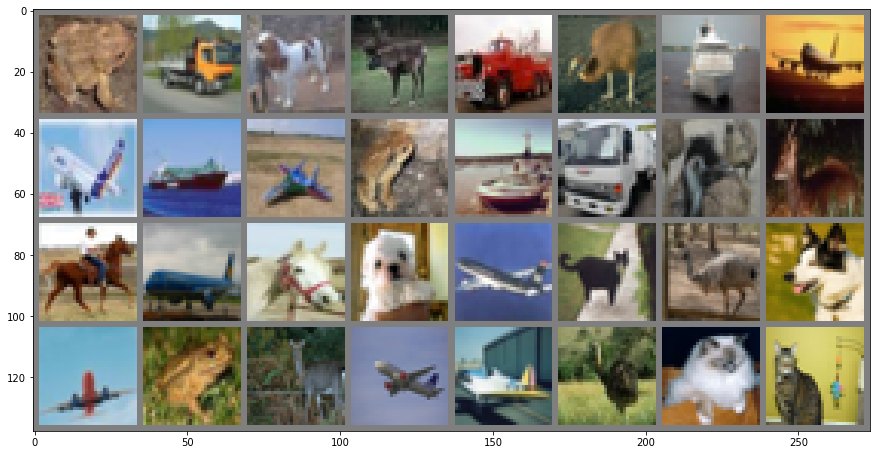

Train Labels: 
 frog truck dog deer truck bird ship plane
 plane ship plane frog ship truck bird deer
 horse plane horse dog plane cat bird dog
 plane frog deer plane plane bird cat cat



In [6]:
# Visualization of Dataset
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Train Labels: \n', ' '.join(f'{classes[labels[j]]}\n' if j % 8 == 7 else f'{classes[labels[j]]}' for j in range(32)))

In [9]:
# Model: Custom Convolutional Network
import torch.nn as nn
import torchvision.models as models

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = ConvNet().to(device)

In [10]:
# Loss function and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
# Training 
def train(model):
    epochs = 2
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print(f'[{epoch + 1}] average loss per epoch: {running_loss / len(train_loader):.3f}')

    print('Finished Training')
    torch.save(model.state_dict(), PATH)

In [12]:
train(net)

[1] average loss per epoch: 2.287
[2] average loss per epoch: 1.867
Finished Training


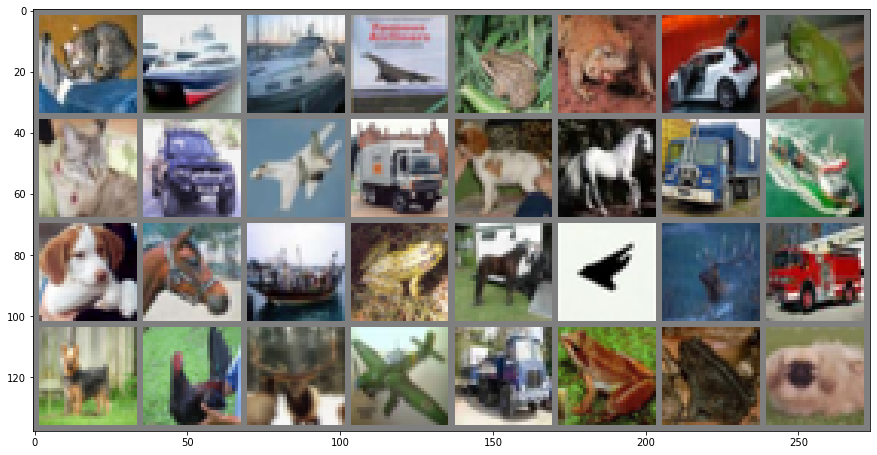

GroundTruth: 
 cat ship ship plane frog frog car frog
 cat car plane truck dog horse truck ship
 dog horse ship frog horse plane deer truck
 dog bird deer plane truck frog frog dog



In [13]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join(f'{classes[labels[j]]}\n' if j % 8 == 7 else f'{classes[labels[j]]}' for j in range(32)))

In [14]:
net = ConvNet()
net.load_state_dict(torch.load(PATH))
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

In [15]:
outputs = net(images.to(device))

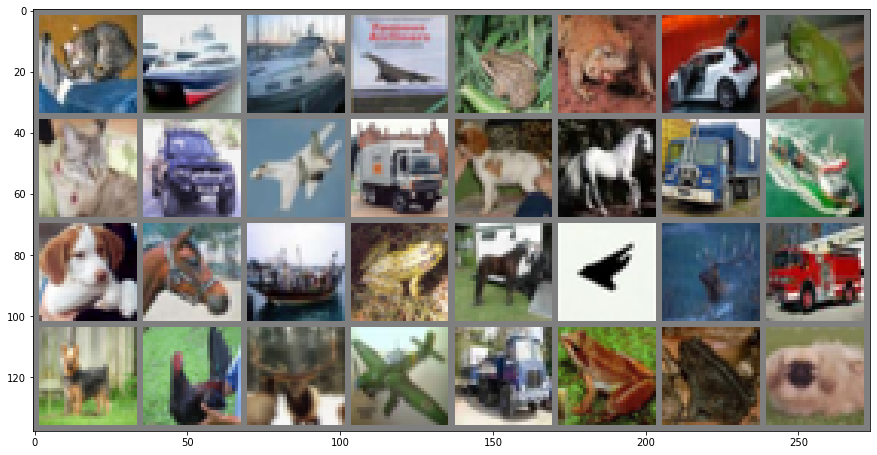

Predicted: 
 cat ship car plane frog frog car frog
 dog car plane car cat car car plane
 cat cat car deer horse plane plane truck
 horse frog frog horse car frog cat horse



In [16]:
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('Predicted: \n', ' '.join(f'{classes[predicted[j]]}\n' if j % 8 == 7 else f'{classes[predicted[j]]}' for j in range(BATCH_SIZE)))

In [17]:
def test(model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest value is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total, correct

total, correct = test(net)
print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 37 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.



## Fully connected network

What if we repeat the procedure for a simpler architecture?


In [18]:
# same architecture as before except the convolutional layers

class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32 , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = FCNet().to(device)

In [19]:
# Comparison 
train(net)


[1] average loss per epoch: 2.307
[2] average loss per epoch: 2.307
Finished Training


In [20]:
total, correct = test(net)
print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %


## Why are ConvNets better?
Convolutions for images are correlations!

Convolution would need to take the symmetric version of the kernel and apply it to the image. However since the kernel is trainable whichever operation we use results to the same performance.


https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
[<img src="https://developer.nvidia.com/sites/default/files/pictures/2018/convolution-2.gif">](convolution)


Convolutional layers detect pattern on images. 

Images with high pattern response are classified accordingly.

In [21]:
# Famous network architectures
# Efficient-Net
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True).to(device)
# ResNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [22]:
for name, param in model.named_parameters():
    print(name)
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# then finetuning on downstream task (in our case CIFAR10)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [23]:
model.fc.weight.shape 
model.fc = nn.Linear(512, 10)

torch.Size([1000, 512])

# References 
Part of the code: 
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Convolution Gif:
https://developer.nvidia.com/discover/convolution

Convolution vs Correlation
https://towardsdatascience.com/convolution-vs-correlation-af868b6b4fb5

Image Classification on CIFAR-10:
https://paperswithcode.com/sota/image-classification-on-cifar-10